In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import deque
import random

In [2]:
class BitFlip():
    '''
    This is the BitFlip environment, the task is to turn
    the bits of the initial random state in specific 
    number of steps to match the final goal. The goal
    is generated randomly in each episode so it is a 
    multi goal environment
    '''
    def __init__(self, n, reward_type):
        '''
        This function initializes the initial variables
        '''
        self.n = n # number of bits
        self.reward_type = reward_type
    def reset(self):
        '''
        This function is for reseting the bitflip
        world
        '''
        self.goal = np.random.randint(2, size=(self.n)) # a random sequence of 0's and 1's
        self.state = np.random.randint(2, size=(self.n)) # another random sequence of 0's and 1's as initial state
        return np.copy(self.state), np.copy(self.goal)
    def step(self, action):
        '''
        This function flips the respective called bits
        '''
        self.state[action] = 1-self.state[action] # flip this bit
        done = np.array_equal(self.state, self.goal)
        if self.reward_type == 'sparse':
            reward = 0 if done else -1
        else:
            reward = -np.sum(np.square(self.state-self.goal))
        return np.copy(self.state), reward, done
    def render(self):
        '''
        This function renders the output
        '''
        print("\rstate :", np.array_str(self.state), end=' '*10)

In [3]:
class Double_DQN:
    '''
    This is the double DQN architecture
    '''
    def __init__(self, state_size, action_size, goal_size):
        '''
        Initializing the varibles
        '''
        ## Input state size
        self.state_size = state_size
        ## Output action size
        self.action_size = action_size
        ## Output goal size
        self.goal_size = goal_size
        ## Epsilon greedy value
        self.epsilon = 0.2
        ## Minimum epsilon value
        self.epsilon_min = 0.02
        ## Decay of epsilon at each step
        self.epsilon_decay = 0.95
        ## This is the weight decay while transferring the
        ## weights from eval network to target network
        self.tau = 0.95 
        ## This is the discount factor
        self.gamma = 0.98
        ## Batch size for training
        self.batch_size = 128
        ## Learning Rate
        self.learning_rate = 1e-3
        ## Creating eval network
        self.q_eval_network = self.create_actor_network()
        ## Creating target network
        self.target_network = self.create_actor_network()
        ## Loss Optimizer declaration 
        self.loss_optimizer = Adam(self.learning_rate)
        ## Loss count
        self.losses = list()
    
    def mean_loss_calculation(self):
        mean_loss = sum(self.losses) / len(self.losses)
        self.losses = list()
        return mean_loss
    
    def create_actor_network(self):
        '''
        This function creates the actor network
        '''
        ## Input state and goal
        state = Input((self.state_size,))
        goal = Input((self.goal_size,))
        ## Concate the state and goal
        x = Concatenate()([state, goal])
        ## Fully connected layer with relu
        x = Dense(256, activation="relu")(x)
        ## Output the action which needs to be taken
        out = Dense(self.action_size)(x)
        return Model([state, goal], out)

    def update(self, state_batch, next_state_batch, goal_batch, action_batch, reward_batch,done_batch):
        '''
        This is the learning pipeline(Backpropogation) of the eval network
        '''
        with tf.GradientTape() as tape:
            ## Calculating best action taken if given next state
            q_eval_next_best_action = self.q_eval_network([next_state_batch,goal_batch],training=True)
            ## Extrating the actions
            next_best_action = tf.math.argmax(q_eval_next_best_action, 1)
            ## taking the actions predicted by the target network
            target_predictions = self.target_network([next_state_batch,goal_batch],training=False)
            ## Calculating the updates for doubling DQN
            q_target_value = tf.math.reduce_sum(target_predictions * \
                                           tf.one_hot(next_best_action, self.action_size), axis=1)
            q_target_value = reward_batch + self.gamma * (1-done_batch) * q_target_value
            q_target_value = tf.clip_by_value(q_target_value, -1/(1-self.gamma), 0)
            q_eval_predictions = self.q_eval_network([state_batch,goal_batch],training=True)
            q_eval_action_value = tf.math.reduce_sum(q_eval_predictions * \
                                                tf.one_hot(action_batch, self.action_size), axis=1)
            ##Final loss
            loss = tf.keras.losses.mean_squared_error(q_target_value, q_eval_action_value)
        self.losses.append(loss.numpy())
        ## Calculating gradients with respect to trainable parameters
        q_eval_network_grad = tape.gradient(loss, self.q_eval_network.trainable_variables)
        ## Applying the gradients
        self.loss_optimizer.apply_gradients(zip(q_eval_network_grad, self.q_eval_network.trainable_variables))
        
    def optimize_batch(self, batch):
        '''
        This function optimizes the model for the given batch
        '''
        ## Converting batch to tensorflow processable tensors
        state_batch = tf.convert_to_tensor(batch[0])
        action_batch = tf.convert_to_tensor(batch[1])
        reward_batch = tf.convert_to_tensor(batch[2])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(batch[3])
        done_batch = tf.convert_to_tensor(batch[4])
        goal_batch = tf.convert_to_tensor(batch[5])
        ## Backpropagation
        self.update(state_batch, next_state_batch, goal_batch, action_batch, reward_batch,done_batch)
        
    def choose_action(self, state, goal):
        '''
        This function chosses the action given state and goal
        '''
        ## Epsilon Greedy
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        action = tf.squeeze(self.q_eval_network([state,goal])).numpy()
        return np.argmax(action)

    def update_weights(self):
        '''
        Updating the eval weights with the target weights for
        stable learning
        '''
        W, target_W = self.q_eval_network.get_weights(), self.target_network.get_weights()
        for i in range(len(W)):
            target_W[i] = self.tau * W[i] + (1 - self.tau)* target_W[i]
        self.target_network.set_weights(target_W)
        ## Epsilon decay
        self.epsilon = max(self.epsilon*self.epsilon_decay, self.epsilon_min)

In [4]:
class Hindsight_experience_replay:
    '''
    This is the Replay buffer
    '''
    def __init__(self, memory_size):
        '''
        Initializing the buffer
        '''
        ## Maximum memory size
        self.buffer_size = memory_size
        ## memory buffer
        self.replay_memory = deque(maxlen = self.buffer_size)
        ## episode buffer
        self.episode_memory = deque(maxlen = self.buffer_size)
    
    def add_episode_mem(self, experience):
        '''
        This is adding experience to the episode memory
        '''
        self.episode_memory.append(experience)
    
    def add_replay_mem(self, experience):
        '''
        This is adding experience to replay memory
        '''
        self.replay_memory.append(experience)
        
    def sample(self, batch_size):
        '''
        Sampling random batch from the memory
        '''
        ## Generating random batch
        index = random.sample([j for j in range(len(self.replay_memory))],batch_size)
        ## converting to batch
        replay_state = [self.replay_memory[i][0] for i in index]
        replay_action = [self.replay_memory[i][1] for i in index]
        replay_reward = [self.replay_memory[i][2] for i in index]
        replay_next_state = [self.replay_memory[i][3] for i in index]
        replay_done = [self.replay_memory[i][4] for i in index]
        replay_goal = [self.replay_memory[i][5] for i in index]
#         index = index.tolist()
#         index.sort(reverse=True) 
#         for i in index:
#             del self.replay_memory[i]
        return [replay_state,replay_action,replay_reward,replay_next_state,replay_done,replay_goal]
    
    def empty_memory(self):
        '''
        This function empties the epsiode memory
        '''
        self.episode_memory.clear()

In [5]:
size = 30
env = BitFlip(size, 'sparse')
agent = Double_DQN(size, size, size)
## total epochs
num_epochs = 250
## Total number of episodes in each epoch
num_episodes = 16
## Agent training steps
optimization_steps = 40
## Batch size
batch_size = 128
losses = list()

success_rate = []
## Experience Replay memory
her_action_replay_memory = Hindsight_experience_replay(10000000)

## Training algorithm
for i in range(num_epochs):
    successes = 0
    ## Running Epoch
    for n in range(num_episodes):
        state, goal = env.reset()
        her_action_replay_memory.empty_memory()
        for t in range(size):
            ## Choosing action
            action = agent.choose_action(np.array([state]), np.array([goal]))
            ## Taking action
            next_state, reward, done = env.step(action)
            ## Creating experience
            new_done = 0.0 if not np.array_equal(next_state, goal) else 1.0
            experience = (state, action, reward, next_state, new_done, goal)
            ## Adding experience
            her_action_replay_memory.add_replay_mem(experience)
            her_action_replay_memory.add_episode_mem(experience)
            state = next_state
            if done:
                break
        successes += done
    ## Training agent
    for steps in range(optimization_steps):
        ##  Batch extraction
        optimize_batch = her_action_replay_memory.sample(batch_size)
        ## Optimize batch
        agent.optimize_batch(optimize_batch)
    ## Updating weights
    agent.update_weights()
    losses.append(agent.mean_loss_calculation())
    success_rate.append(successes/num_episodes)
    print("\repoch", i+1, "success rate", success_rate[-1],'loss %.2f'%losses[-1], 'exploration %.2f'%agent.epsilon, end=' '*10)

2021-12-20 09:42:54.623240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 09:42:54.632577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 09:42:54.632904: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-20 09:42:54.633758: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

epoch 250 success rate 0.0 loss 0.06 exploration 0.02          

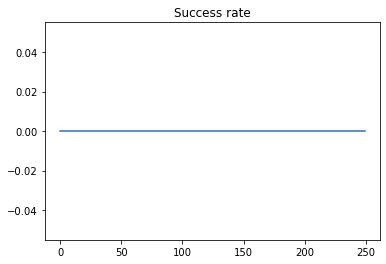

In [6]:
plt.title('Success rate')
plt.plot(success_rate)
plt.show()

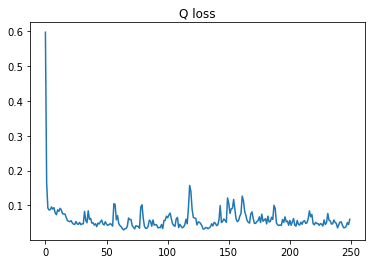

In [7]:
plt.title('Q loss')
plt.plot(losses)
plt.show()